In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import os
from pyspark.sql import Row
from graphframes import GraphFrame

In [4]:

def buildEdgesLabels(InGraph:GraphFrame):
    edgeLabels = {}
    # edgeList is a list of spark dataframe rows
    edgeList = InGraph.edges.collect()
    for edgeItem in edgeList:
        edgeLabels[(edgeItem["src"], edgeItem["dst"])]=edgeItem["type"]
    return edgeLabels

def drawGraph(InGraph:GraphFrame):
    nxGraph = nx.Graph()
    for edge in InGraph.edges.collect():
        nxGraph.add_edge(edge["src"], edge["dst"])
    
    # Define layout
    pos = nx.spring_layout(nxGraph, seed=42)
    
    # Draw nodes and edges
    nx.draw(nxGraph, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black')
    nx.draw_networkx_edge_labels(nxGraph, pos, edge_labels=buildEdgesLabels(InGraph))
    
    plt.show()

In [5]:


local=True
if local:
    spark = SparkSession.builder\
        .master("local[4]")\
        .appName("RepartitionAndCoalesce")\
        .config("spark.executor.memory", "4g")\
        .config('spark.jars.packages','graphframes:graphframes:0.8.2-spark3.2-s_2.12') \
        .getOrCreate()
else:
    spark = SparkSession.builder\
        .master("k8s://https://kubernetes.default.svc:443")\
        .appName("RepartitionAndCoalesce")\
        .config("spark.kubernetes.container.image", "inseefrlab/jupyter-datascience:master")\
        .config("spark.kubernetes.authenticate.driver.serviceAccountName", os.environ['KUBERNETES_SERVICE_ACCOUNT'])\
        .config('spark.jars.packages','graphframes:graphframes:0.8.2-spark3.2-s_2.12') \
        .config("spark.executor.instances", "4")\
        .config("spark.executor.memory","2g")\
        .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE'])\
        .getOrCreate()

# make the large dataframe show pretty
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

23/09/28 10:25:37 WARN Utils: Your hostname, pengfei-Virtual-Machine resolves to a loopback address: 127.0.1.1; using 10.50.2.80 instead (on interface eth0)
23/09/28 10:25:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/pengfei/opt/spark-3.3.0/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/pengfei/.ivy2/cache
The jars for the packages stored in: /home/pengfei/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5751e70e-979d-48a4-95ba-f6c8474e031f;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 409ms :: artifacts dl 5ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	-------------------------------

23/09/28 10:25:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/09/28 10:25:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [6]:


vertices = spark.createDataFrame([('D1', 'Carter', 'Derrick', "dentist",50),
                                  ('D2', 'May', 'Derrick', "pediatrician",26),
                                 ('D3', 'Mills', 'Jeff', "ophthalmo",80),
                                  ('D4', 'Hood', 'Robert', "general_practitioner" ,65),
                                  ('D5', 'Banks', 'Mike', "surgeon",93),
                                 ('D6', 'Berg', 'Tim', "general_practitioner" ,28),
                                 ('D7', 'Page', 'Allan',"general_practitioner" ,16),
                                 ('D8', 'Carter', 'Derrick', "dentist", 50),
                                  ('P1', 'Foo', 'Bar',"patient", 26),
                                  ('P2', 'May', 'Derrick',"patient", 26),
                                 ('P3', 'Mills', 'Jeff', "patient",80),
                                  ('P4', 'Hood', 'Robert', "patient",65),
                                  ('P5', 'Banks', 'Mike', "patient",93),
                                 ('P6', 'Berg', 'Tim', "patient",28),
                                 ('P7', 'Page', 'Allan', "patient",16),
                                 ('P8', 'Foo', 'Bar',"patient", 26),
                                  ('P9', 'May', 'Derrick',"patient", 26),
                                 ('P10', 'Mills', 'Jeff', "patient",80),
                                  ('P11', 'Hood', 'Robert', "patient",65),
                                  ('P12', 'Banks', 'Mike', "patient",93),
                                 ('P13', 'Berg', 'Tim', "patient",28),
                                 ('P14', 'Page', 'Allan', "patient",16)
                                  ],
                                 ['id', 'name', 'firstname', "category",'age'])

edges = spark.createDataFrame([('D2', 'P14', 'treat'),
                              ('D3', 'P1', 'treat'),
                              ('D1', 'P3', 'treat'),                
                               ('D4', 'P1', 'treat'),
                               ('D4', 'P2', 'treat'),
                               ('D4', 'P3', 'treat'),
                               ('D4', 'P4', 'treat'),
                               ('D6', 'P5', 'treat'),
                               ('D6', 'P6', 'treat'),
                               ('D6', 'P7', 'treat'),
                               ('D6', 'P8', 'treat'),
                               ('D7', 'P9', 'treat'),
                               ('D7', 'P10', 'treat'),
                               ('D7', 'P11', 'treat'),
                               ('D7', 'P12', 'treat'),
                               ('D5', 'P10', 'treat'),
                               ('D5', 'P12', 'treat'),
                               ('D1', 'P2', 'treat'),
                               ('D1', 'P7', 'treat'),
                               ('D1', 'P8', 'treat'),
                               ('D1', 'P9', 'treat'),
                               ('D1', 'P10', 'treat'),
                               ('D8', 'P2', 'treat'),
                               ('D8', 'P3', 'treat'),
                               ('D8', 'P4', 'treat'),
                               ('D8', 'P5', 'treat'),
                               ('D8', 'P6', 'treat'),   
                               ('P3', 'P14', 'parent')
                              ],
                              ['src', 'dst', 'type'])


In [7]:


graph = GraphFrame(vertices, edges)


/home/pengfei/.cache/pypoetry/virtualenvs/sparkcommonfunc-jby-k8HJ-py3.8/lib/python3.8/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [8]:
graph.vertices.show()

+---+------+---------+--------------------+---+
| id|  name|firstname|            category|age|
+---+------+---------+--------------------+---+
| D1|Carter|  Derrick|             dentist| 50|
| D2|   May|  Derrick|        pediatrician| 26|
| D3| Mills|     Jeff|           ophthalmo| 80|
| D4|  Hood|   Robert|general_practitioner| 65|
| D5| Banks|     Mike|             surgeon| 93|
| D6|  Berg|      Tim|general_practitioner| 28|
| D7|  Page|    Allan|general_practitioner| 16|
| D8|Carter|  Derrick|             dentist| 50|
| P1|   Foo|      Bar|             patient| 26|
| P2|   May|  Derrick|             patient| 26|
| P3| Mills|     Jeff|             patient| 80|
| P4|  Hood|   Robert|             patient| 65|
| P5| Banks|     Mike|             patient| 93|
| P6|  Berg|      Tim|             patient| 28|
| P7|  Page|    Allan|             patient| 16|
| P8|   Foo|      Bar|             patient| 26|
| P9|   May|  Derrick|             patient| 26|
|P10| Mills|     Jeff|             patie

In [9]:
graph.edges.show()

+---+---+-----+
|src|dst| type|
+---+---+-----+
| D2|P14|treat|
| D3| P1|treat|
| D1| P3|treat|
| D4| P1|treat|
| D4| P2|treat|
| D4| P3|treat|
| D4| P4|treat|
| D6| P5|treat|
| D6| P6|treat|
| D6| P7|treat|
| D6| P8|treat|
| D7| P9|treat|
| D7|P10|treat|
| D7|P11|treat|
| D7|P12|treat|
| D5|P10|treat|
| D5|P12|treat|
| D1| P2|treat|
| D1| P7|treat|
| D1| P8|treat|
+---+---+-----+


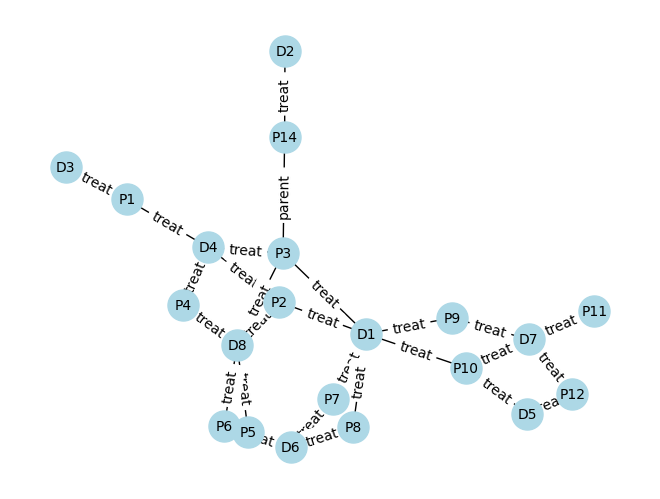

In [10]:
drawGraph(graph)

# Q1. How many general_practitioner is in the dataset

In [12]:
from pyspark.sql.functions import col
generalist = graph.vertices.filter(col("category")=="general_practitioner")
print(f"There are {generalist.count()} general_practitioner")
generalist.show()

There are 3 general_practitioner
+---+----+---------+--------------------+---+
| id|name|firstname|            category|age|
+---+----+---------+--------------------+---+
| D4|Hood|   Robert|general_practitioner| 65|
| D6|Berg|      Tim|general_practitioner| 28|
| D7|Page|    Allan|general_practitioner| 16|
+---+----+---------+--------------------+---+


# Q2. Who is the most popular doctor and which patient sees the most doctors


In [17]:
# as the graph is directed, so we can use in out to distinct the doctor and patient.
bestDoctors = graph.outDegrees.sort("outDegree", ascending=False)
bestDoctors.show()

+---+---------+
| id|outDegree|
+---+---------+
| D1|        6|
| D8|        5|
| D6|        4|
| D4|        4|
| D7|        4|
| D5|        2|
| D3|        1|
| D2|        1|
| P3|        1|
+---+---------+


In [19]:
patientInTrouble = graph.inDegrees.sort("inDegree", ascending=False)
patientInTrouble.show()

+---+--------+
| id|inDegree|
+---+--------+
| P3|       3|
| P2|       3|
|P10|       3|
| P4|       2|
|P14|       2|
| P8|       2|
| P6|       2|
| P1|       2|
| P7|       2|
| P5|       2|
| P9|       2|
|P12|       2|
|P11|       1|
+---+--------+


When we try to create different types of nodes in a graphe, we have difficulties. Because we use one data frame to build the vertexs. And a dataframe can't have two different schema. I found a https://stackoverflow.com/questions/33241332/how-to-create-a-bipartite-graph-in-graphx

It uses RDD to do the job. Need to test if possible with python.

Another solution is to build a parent Class which can be subclass for the different node type. In our case, if there are a patient type node, and a doctor type node. We need to create a person class which contains not only all required attributes of doctor and patient, but also an extra attribute such as `profession` which distinct the patient and doctor

In [23]:
# Define vertices for partite A
patients = spark.createDataFrame([
   ("patient 1", 12, "1st rue toto"),
   ("patient 2", 26, "1st rue t1t1"),
   # Add more vertices for partite A as needed
], ["name","age","address"])

# Define vertices for partite B
docs = spark.createDataFrame([
   ("doctor1", "hospital1", "2 rue toto"),
   ("doctor2", "hospital2", "3 rue toto"),
   # Add more vertices for partite B as needed
], ["name", "hospital_name", "hostpital_address"])

# Define edges connecting partite A to partite B
edges = spark.createDataFrame([
   (1, 101, "see doctor"),
   (2, 102, "see doctor"),
    (1, 102, "see doctor"),
   (2, 101, "see doctor"),
   # Add more edges as needed
], ["src", "dst", "relationship"])

# Create GraphFrames for partite A and B
graph_A = GraphFrame(patients, edges)
graph_B = GraphFrame(docs, edges)

# Merge the vertices and edges of both GraphFrames to create a bipartite graph
merged_vertices = patients.union(docs)
merged_edges = edges
bipartite_graph = GraphFrame(merged_vertices, merged_edges)



ValueError: Vertex ID column id missing from vertex DataFrame, which has columns: name,age,address

KeyError: 'type'

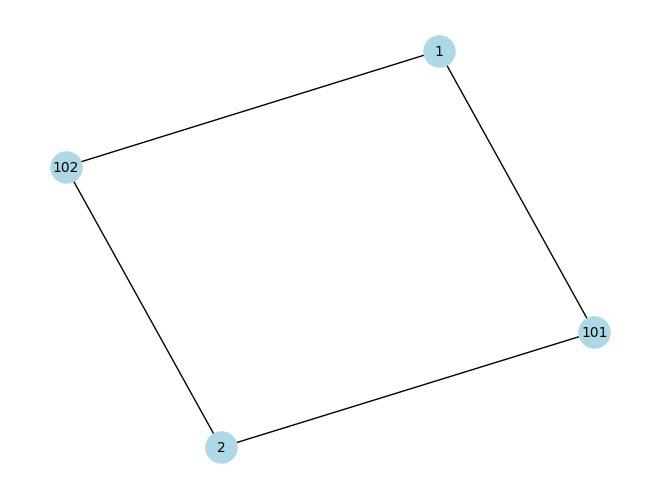

In [22]:
nx_graph = nx.Graph()
for edge in bipartite_graph.edges.collect():
    nx_graph.add_edge(edge["src"], edge["dst"])

# Define layout
pos = nx.spring_layout(nx_graph, seed=42)

# Draw nodes and edges
nx.draw(nx_graph, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black')
labels = {edge: data["type"] for edge, data in nx_graph.edges.items()}
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=labels)

plt.show()